<a href="https://colab.research.google.com/github/Yassine-Sebri/Advanced-Data-Science-Specializaton-Capstone/blob/master/Feature%20Engineering%20and%20Modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%tensorflow_version 2.x

TensorFlow 2.x selected.


In [0]:
# Essentials
import numpy as np
import pandas as pd

import warnings
warnings.simplefilter('ignore')

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# Models
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras import models
from tensorflow.keras.layers import Input, Dense, Dropout

# Misc
from collections import Counter
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from bs4 import BeautifulSoup             
import re
import random
from sklearn import preprocessing
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.model_selection import train_test_split
from joblib import dump
nltk.download('all')

In [3]:
# Reading data
data = pd.read_csv("/content/drive/My Drive/IBM Advanced Data Science Capstone/IMDB Dataset.csv")
data.shape

(50000, 2)

##Preprocessing

In [0]:
# Label encoding
label_encoder = preprocessing.LabelEncoder()
data['sentiment'] = label_encoder.fit_transform(data['sentiment'])

In [5]:
def preprocessing(raw_review):
    # 1. Remove HTML
    review_text = BeautifulSoup(raw_review).get_text() 

    # 2. Remove non-letters        
    letters_only = re.sub("[^a-zA-Z]", " ", review_text) 

    # 3. Convert to lower case, split into individual words
    words = letters_only.lower().split()                             

    # 4. Converting to set for better time complexity
    stops = set(stopwords.words("english"))                  

    # 5. Remove stop words
    meaningful_words = [w for w in words if not w in stops]   

    # 6. Join the words back into one string separated by space, 
    # and return the result.
    return( " ".join( meaningful_words))  
 
index = random.randrange(50000)

print("Original review: {}".format(data.review.values[index]))
print("Preprocessed : {}".format(preprocessing(data.review.values[index])))

Original review: Best animated movie ever made. This film explores not only the vast world of modern animation with absolutely boggling effects, but the branches of the human mind, soul, and philosophy. The story features a family of cats, where in the big sister dies, the younger brother sees this and rescues her body, but when she awakens she is left without a soul. So, the two sibling cats embark on a journey to find it. I have related this journey to many things. The history of the world, the bible, the cycle of life, and every time I watch it I discover more and more hidden themes and metaphors. If you aren't so into the physiological aspect of it then, you will still adore it. The animation is superb, and the creative scenes will have you attached to the screen. For example, the ocean freezing in time, god eating soup out of the earth, a strange and slightly SNM retelling of Hansel and Gretel. To conclude, Cat Soup is an absolute treat for anyone.<br /><br />PS- Not for kids, gra

In [0]:
preprocessed_data = data
preprocessed_data['review'] = preprocessed_data['review'].apply(preprocessing)
preprocessed_data.to_csv('Preprocessed_data.csv', index=False)

##Feature Engineering

In [7]:
# Let's check the dimensionality of transformed text
tfidf = TfidfVectorizer()
tr_texts = tfidf.fit_transform(preprocessed_data['review'])
tr_texts.shape

(50000, 101227)

In [8]:
# Let's try to reduce the dimensionality
NGRAM_RANGE = (1, 2)
TOP_K = 20000
TOKEN_MODE = 'word'
MIN_DOC_FREQ = 2

def ngram_vectorize(texts, labels):
    kwargs = {
        'ngram_range' : NGRAM_RANGE,
        'dtype' : 'int32',
        'strip_accents' : 'unicode',
        'decode_error' : 'replace',
        'analyzer' : TOKEN_MODE,
        'min_df' : MIN_DOC_FREQ,
    }
    # Learn Vocab from train texts and vectorize train and val sets
    tfidf_vectorizer = TfidfVectorizer(**kwargs)
    transformed_texts = tfidf_vectorizer.fit_transform(texts)
    dump(tfidf_vectorizer, "tfidf_vectorizer.joblib")
    
    # Select best k features, with feature importance measured by f_classif
    # Set k as 20000 or (if number of ngrams is less) number of ngrams   
    selector = SelectKBest(f_classif, k=min(TOP_K, transformed_texts.shape[1]))
    selector.fit(transformed_texts, labels)
    transformed_texts = selector.transform(transformed_texts).astype('float32')
    dump(selector, "selector.joblib")
    return transformed_texts

# Vectorize the data
vect_data = ngram_vectorize(preprocessed_data['review'], preprocessed_data['sentiment'])
vect_data.shape

(50000, 20000)

##Modeling

In [9]:
# Split data to target y and features X
X = vect_data.toarray()
y = np.array(data['sentiment'])

# Here we split data to training and testing parts
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Train dataset shape: {0}, \nTest dataset shape: {1}".format(X_train.shape, X_test.shape))

Train dataset shape: (40000, 20000), 
Test dataset shape: (10000, 20000)


###Classic Models

In [0]:
# Naive Bayes
clf = MultinomialNB()
clf.fit(X_train, y_train)
nb_accuracy = clf.score(X_test, y_test)

In [0]:
# Random Forest
rf = RandomForestClassifier(n_estimators = 100)
rf.fit(X_train, y_train)
rf_accuracy = rf.score(X_test, y_test)

###Deep Learning

In [12]:
input_shape = X_train.shape[1:]

model = Sequential()
model.add(Input(shape=input_shape))
model.add(Dense(units=64, activation='relu'))
model.add(Dropout(rate=0.5))
model.add(Dense(units=64, activation='relu'))
model.add(Dropout(rate=0.5))
model.add(Dense(units=1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                1280064   
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 1,284,289
Trainable params: 1,284,289
Non-trainable params: 0
_________________________________________________________________


In [0]:
LEARNING_RATE = 1e-3

loss = 'binary_crossentropy'

optimizer = tf.keras.optimizers.Adam(lr=LEARNING_RATE)
model.compile(optimizer=optimizer, loss=loss, metrics=['acc'])

In [14]:
EPOCHS = 5
BATCH_SIZE = 64

# Train and validate model
# To start training, call the model.fit method—the model is "fit" to the training data.
# Note that fit() will return a History object which we can use to plot training vs. validation accuracy and loss.
history = model.fit(X_train, y_train, epochs=EPOCHS, validation_data=(X_test, y_test), verbose=1, 
                    batch_size=BATCH_SIZE)

Train on 40000 samples, validate on 10000 samples
Epoch 1/5
40000/40000 [==============================] - 4s 99us/sample - loss: 0.3043 - acc: 0.8818 - val_loss: 0.1878 - val_acc: 0.9254
Epoch 2/5
40000/40000 [==============================] - 3s 83us/sample - loss: 0.1518 - acc: 0.9446 - val_loss: 0.1944 - val_acc: 0.9246
Epoch 3/5
40000/40000 [==============================] - 3s 82us/sample - loss: 0.1017 - acc: 0.9640 - val_loss: 0.2033 - val_acc: 0.9264
Epoch 4/5
40000/40000 [==============================] - 3s 83us/sample - loss: 0.0691 - acc: 0.9769 - val_loss: 0.2259 - val_acc: 0.9253
Epoch 5/5
40000/40000 [==============================] - 3s 81us/sample - loss: 0.0463 - acc: 0.9848 - val_loss: 0.2593 - val_acc: 0.9246


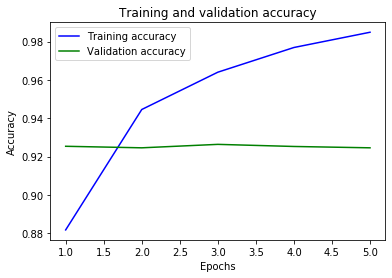

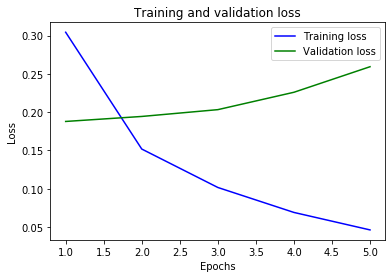

In [15]:
# Let's plot training and validation accuracy as well as loss.
def plot_history(history):
    accuracy = history.history['acc']
    val_accuracy = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    epochs = range(1,len(accuracy) + 1)
    
    # Plot accuracy  
    plt.figure(1)
    plt.plot(epochs, accuracy, 'b', label='Training accuracy')
    plt.plot(epochs, val_accuracy, 'g', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Plot loss
    plt.figure(2)
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'g', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

plot_history(history)

###Model Comparison

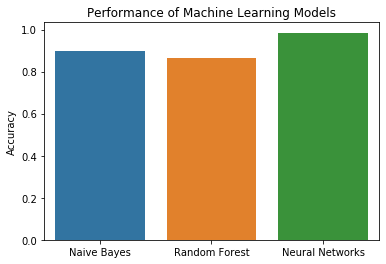

In [16]:
y_pos = np.arange(3)
sns.barplot(y_pos, [nb_accuracy, rf_accuracy, max(history.history['acc'])]);
plt.title("Performance of Machine Learning Models");
plt.ylabel("Accuracy");
plt.xticks(y_pos, ("Naive Bayes", "Random Forest", "Neural Networks"));

In [0]:
# Saving the Neural Networks model
model.save('NN_model.h5')